In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn as sk
import xgboost as xgb
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import sklearn.ensemble as ensemble
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_validate, KFold
from tensorflow.keras.utils import to_categorical

2024-07-12 17:11:08.677195: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 17:11:08.724966: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-12 17:11:09.062036: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-12 17:11:09.063795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Directory containing the CSV files
data_dir = '../data'

# Filter tasks and create a dictionary of dataframes
tasks = ['knot', 'rushhour', 'origami', 'cord', 'lego', 'tangrams']
tasks_df = {}
people_df = {}

# Loop through all CSV files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        split_name = filename.split("_")
        if len(split_name) == 2:
            name = split_name[0]
            if name == 'all':
                continue
            elif name in tasks:
                file_path = os.path.join(data_dir, filename)
                tasks_df[name] = pd.read_csv(file_path, low_memory=False)
            else:
                file_path = os.path.join(data_dir, filename)
                people_df[name] = pd.read_csv(file_path, low_memory=False)

In [3]:
# Clean the dat

# Declare label
label_confused = 'confused'
label_help = 'help'
label_both = 'both'
label_neither = 'neither'
label_either = 'either' # Help means you are confused and need help

labels = [label_confused, label_help, label_both, label_neither, label_either]

def clean(df):
    cols = ['body_tracking_error', 'confused', 'help']
    df = df.copy()

    # Define the patterns to filter out for body34
    patterns_to_remove_body34 = [
    r'keypoint_1[8-9]_.*',  # Matches keypoint_18_* and keypoint_19_*
    r'keypoint_2[0-5]_.*', # Matches keypoint_20_* to keypoint_29_*
    r'keypoint_3[2-3]_.*', # Matches keypoint_32_* to keypoint_33_*
    r'keypoint_confidence_1[8-9]',  # Matches keypoint_confidence_18 and keypoint_confidence_19
    r'keypoint_confidence_2[0-5]',  # Matches keypoint_confidence_20 to keypoint_confidence_29
    r'keypoint_confidence_3[2-3]', # Matches keypoint_confidence_32 to keypoint_confidence_33
    r'local_position_per_joint_1[8-9]_.*', # Matches local_position_per_joint_18_* and local_position_per_joint_19_*
    r'local_position_per_joint_2[0-5]_.*', # Matches local_position_per_joint_20_* to local_position_per_joint_29_*
    r'local_position_per_joint_3[2-3]_.*', # Matches local_position_per_joint_32_* to local_position_per_joint_33_*
    r'local_orientation_per_joint_1[8-9]_.*', # Matches local_orientation_per_joint_18_* and local_orientation_per_joint_19_*
    r'local_orientation_per_joint_2[0-5]_.*', # Matches local_orientation_per_joint_20_* to local_orientation_per_joint_29_*
    r'local_orientation_per_joint_3[2-3]_.*'  # Matches local_orientation_per_joint_32_* to local_orientation_per_joint_33_*
    ]

    # Combine patterns into a single regex pattern
    combined_pattern = '|'.join(patterns_to_remove_body34)

    # Filter columns based on the combined pattern
    filtered_columns = df.filter(regex=f'^((?!{combined_pattern}).)*$', axis=1)

    # Assign back to df
    df = df[filtered_columns.columns]

    # drop columns with NaN values in cols
    df = df.dropna(subset=cols)
    for col in cols:
        df[col] = df[col].replace(['False', 'True', '0.0', '1.0'], ['0', '1', '0', '1'])  # Replace string values with integers
        df[col] = df[col].astype('Int64')  # Use 'Int64' for nullable integers in pandas

    # Filter data based on confusion status
    df[label_both] = (df[label_confused] == 1) & (df[label_help] == 1)
    df[label_neither] = (df[label_confused] == 0) & (df[label_help] == 0)
    df[label_either] = (df[label_confused] == 1) | (df[label_help] == 1)
    df[label_confused] = (df[label_confused] == 1) & (df[label_help] == 0)
    df[label_help] = (df[label_help] == 1) & (df[label_confused] == 0)

    #df = df.dropna()
    #return df[(df["body_tracking_error"] == 0) & (df["success"] == 1)]
    return df[(df["body_tracking_error"] == 0)]

def lost_metrics(df, df_filtered):
    # Lost Frames
    print("Original df: ", df.shape)
    print("Filtered df: ", df_filtered.shape)
    print("Lost Frames: ", df.shape[0] - df_filtered.shape[0])
    print()

    for label in labels:
        # Calculate the truth percentage of the total
        if label == label_neither:
            truth_percentage = (df_filtered[label].value_counts(normalize=True).get(0, 0)) * 100
        else:
            truth_percentage = (df_filtered[label].value_counts(normalize=True).get(1, 0)) * 100

        # Display the label and its truth percentage
        print(f'{label}: {truth_percentage:.2f}%')

        # Display the value counts for the label
        value_counts = df_filtered[label].value_counts()
        print(value_counts.to_string(), "\n")  # Converts the Series to a string to format it nicely

    try:
        # Display the shape of the DataFrame
        columns_with_nan = df_filtered.columns[df.isna().any()].tolist()

        # Calculate the number of NaN values for each column with NaNs
        nan_counts = df_filtered[columns_with_nan].isna().sum()

        # Create a bar plot for columns with NaN counts
        plt.figure(figsize=(12, 8))
        nan_counts.plot(kind='bar')
        plt.title('Number of NaN Values per Column')
        plt.xlabel('Columns')
        plt.ylabel('Number of NaN Values')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    except:
        print("No NaN values")

In [4]:
# Create a dictionary to store the cleaned dataframes
tasks_df_filtered = {}
people_df_filtered = {}

# Clean the dataframes
for task, df in tasks_df.items():
    tasks_df_filtered[task] = clean(df)

for person, df in people_df.items():
    people_df_filtered[person] = clean(df)

In [5]:
# Plot AU Intensity

# Facial Action Units (AUs) Intensity
au_columns_r = people_df_filtered[person].filter(regex=r'^AU\d{2}_r', axis=1).columns.tolist()

# Facial Action Units (AUs) Presence
au_columns_c = people_df_filtered[person].filter(regex=r'^AU\d{2}_c', axis=1).columns.tolist()

# Function to calculate mean activations for different labels
def calculate_mean_activations(df):
    mean_activations = {'AU': au_columns_r}
    for label in labels:
        mean_activations[label] = df[df[label] == 1][au_columns_r].mean()
    return mean_activations

# Plotting function
def plot_mean_activations(name, df):
    # Create a new dataframe for visualization
    mean_activations = calculate_mean_activations(df)
    df_means = pd.DataFrame(mean_activations).set_index('AU')

    # Reset the index to plot with seaborn
    df_means_reset = df_means.reset_index().melt(id_vars='AU', var_name='Status', value_name='Mean AU Intensity')

    # Plotting the data with Seaborn
    plt.figure(figsize=(16, 10))
    sns.barplot(x='AU', y='Mean AU Intensity', hue='Status', data=df_means_reset, palette='viridis')

    # Add value labels to each bar
    for p in plt.gca().patches:
        plt.gca().annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

    plt.xlabel('Action Units')
    plt.ylabel('Mean AU Intensity')
    plt.title('Mean Intensity of Action Units for ' + name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
# Function to calculate mean activations for different labels
def calculate_mean_activations(df, au_columns_r, labels):
    mean_activations = {'AU': au_columns_r}
    for label in labels:
        mean_activations[label] = df[df[label] == 1][au_columns_r].mean()
    return mean_activations

# Function to calculate differences
def calculate_differences(mean_activations):
    mean_confused = mean_activations[label_confused]
    mean_help = mean_activations[label_help]
    mean_both = mean_activations[label_both]
    mean_neither = mean_activations[label_neither]
    mean_either = mean_activations[label_either]

    diff_help_confused = mean_help - mean_confused
    diff_confused_neither = mean_confused - mean_neither
    diff_help_neither = mean_help - mean_neither
    diff_both_neither = mean_both - mean_neither
    diff_either_neither = mean_either - mean_neither

    return pd.DataFrame({
        'AU': mean_activations['AU'],
        'Help - Confused': diff_help_confused,
        'Confused - Neither': diff_confused_neither,
        'Help - Neither': diff_help_neither,
        'Both - Neither': diff_both_neither,
        'Either - Neither': diff_either_neither
    }).set_index('AU')

def plot_au_diff_threshold_intensity_heatmap_multiple(names, dfs_filtered, threshold=0.15):
    # Initialize a list to accumulate differences dataframes
    all_differences = []

    # Iterate through each DataFrame
    for name, df_filtered in zip(names, dfs_filtered):
        # Calculate mean activations
        mean_activations = calculate_mean_activations(df_filtered, au_columns_r, labels)
        
        # Calculate differences
        df_differences = calculate_differences(mean_activations)

        # Append to the list with DataFrame name prefixed to columns
        df_differences.columns = [f"{name}: {col}" for col in df_differences.columns]
        all_differences.append(df_differences)

    # Concatenate all differences DataFrames along columns (side by side)
    all_differences_concat = pd.concat(all_differences, axis=1)

    # Plotting differences above a threshold
    df_differences_threshold = all_differences_concat[
        (all_differences_concat > threshold) | (all_differences_concat < -threshold)
    ]
    plt.figure(figsize=(14, 10))
    sns.heatmap(df_differences_threshold, annot=True, cmap='coolwarm', center=0, linewidths=.5, linecolor='black')
    plt.title(f'Differences in Mean Intensity of Action Units above {threshold} Threshold across Datasets', fontsize=16)
    plt.xlabel('Labels Comparison', fontsize=14)
    plt.ylabel('Action Units', fontsize=14)
    plt.xticks(rotation=45, ha='right')  # Rotate and align ticks for better visibility
    plt.tight_layout()
    plt.show()

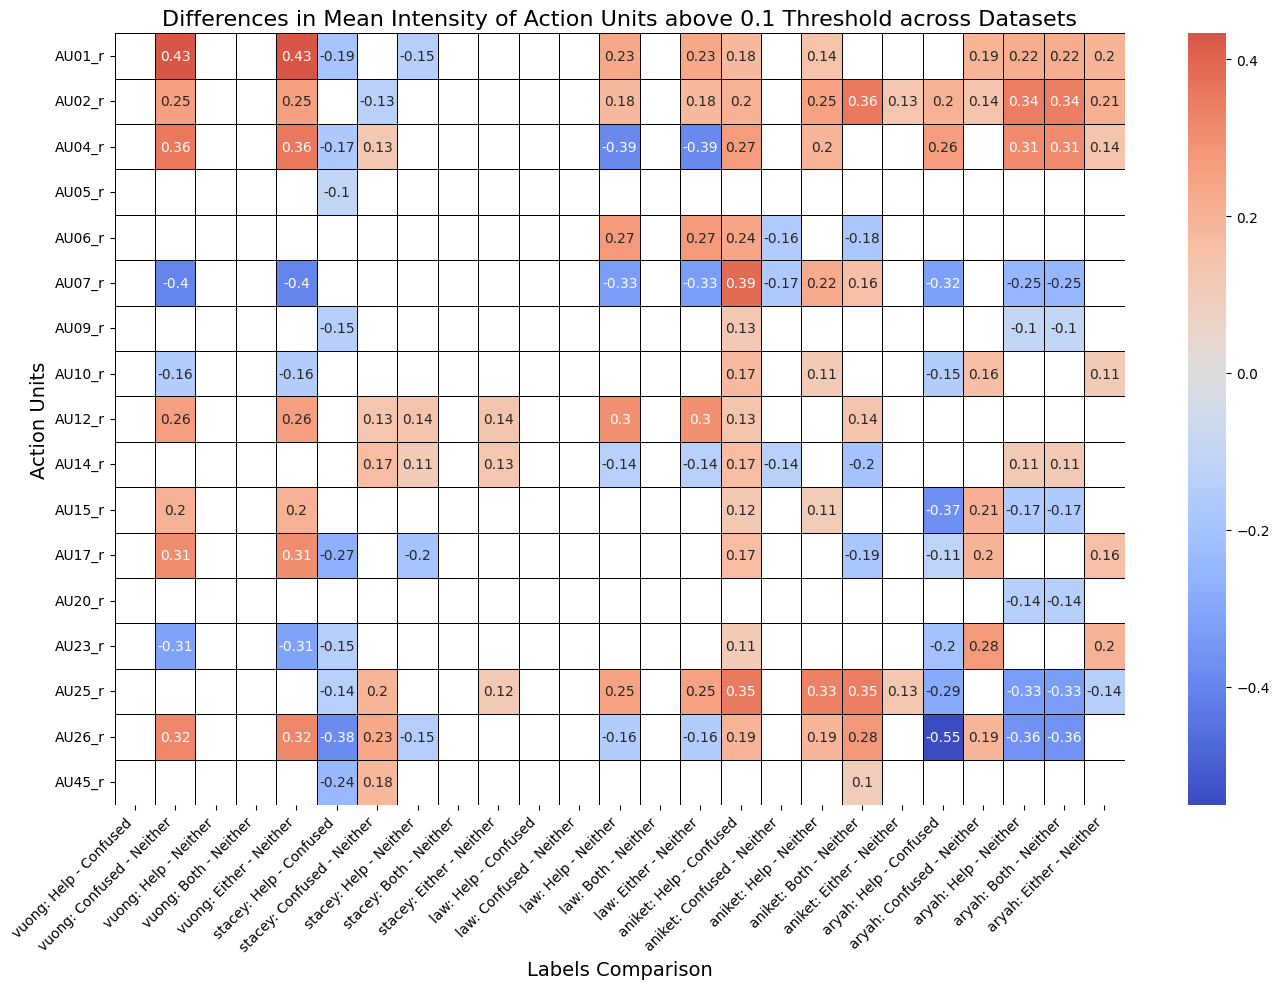

In [7]:
# Example usage: plot differences for multiple datasets
names = list(people_df_filtered.keys())
dfs_filtered = list(people_df_filtered.values())
plot_au_diff_threshold_intensity_heatmap_multiple(names, dfs_filtered, threshold=0.1)

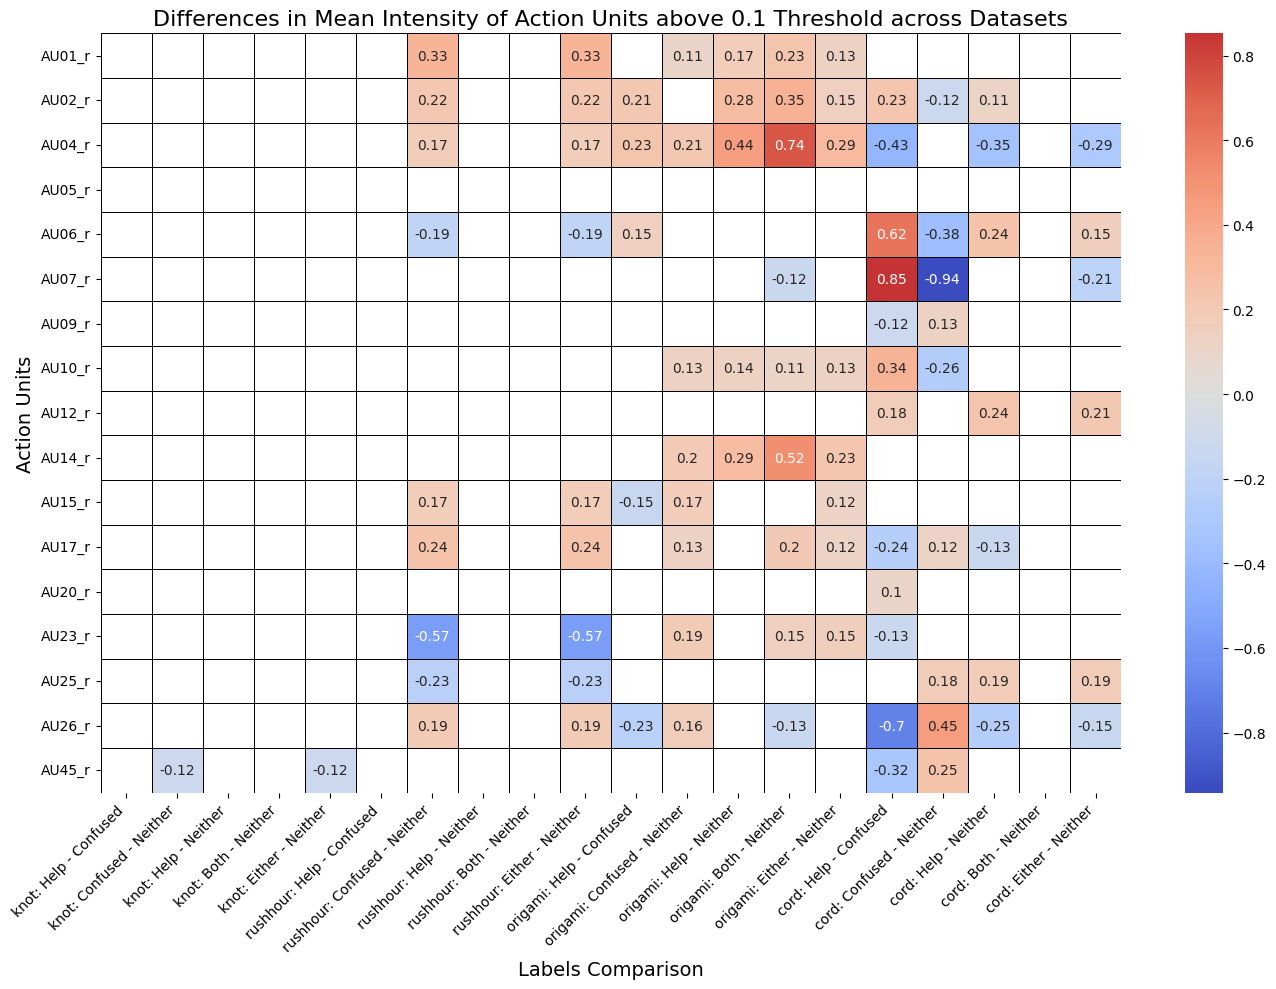

In [8]:
# Example usage: plot differences for multiple datasets
names = list(tasks_df_filtered.keys())
dfs_filtered = list(tasks_df_filtered.values())
plot_au_diff_threshold_intensity_heatmap_multiple(names, dfs_filtered, threshold=0.1)

In [9]:
# Read stacey data
stacey_df = pd.read_csv('./data/stacey_combined.csv', low_memory=False)
stacey_df_filtered = clean(stacey_df)

In [10]:
print(stacey_df[label_confused].value_counts())
print(stacey_df[label_help].value_counts())
print(stacey_df_filtered[label_confused].value_counts())
print(stacey_df_filtered[label_help].value_counts())


confused
0        29264
False    18490
1         2762
True      1139
Name: count, dtype: int64
help
0        26502
False    19629
1         5524
Name: count, dtype: int64
confused
False    47279
True      3751
Name: count, dtype: Int64
help
False    45506
True      5524
Name: count, dtype: Int64


In [11]:
stacey_cord_df = pd.read_csv('./data/2024-06-12_stacey_cord_combined.csv', low_memory=False)
stacey_cord_df_filtered = clean(stacey_cord_df)

In [12]:
print(stacey_cord_df[label_confused].value_counts())
print(stacey_cord_df[label_help].value_counts())
print(stacey_cord_df_filtered[label_confused].value_counts())
print(stacey_cord_df_filtered[label_help].value_counts())

confused
0    14632
1     1381
Name: count, dtype: int64
help
0    13251
1     2762
Name: count, dtype: int64
confused
False    14632
True      1381
Name: count, dtype: Int64
help
False    13251
True      2762
Name: count, dtype: Int64


In [13]:
stacey_origami_df = pd.read_csv('./data/2024-06-12_stacey_origami_combined.csv', low_memory=False)
stacey_origami_df_filtered = clean(stacey_origami_df)

In [14]:
print(stacey_origami_df[label_confused].value_counts())
print(stacey_origami_df[label_help].value_counts())
print(stacey_origami_df_filtered[label_confused].value_counts())
print(stacey_origami_df_filtered[label_help].value_counts())

confused
False    18490
True      1139
Name: count, dtype: int64
help
False    19629
Name: count, dtype: int64
confused
False    18015
True       989
Name: count, dtype: Int64
help
False    19004
Name: count, dtype: Int64
